In [1]:
import os,sys
import numpy as np
import pandas as pd
import collections
import pickle as pk
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr, spearmanr, chisquare, ttest_1samp, ranksums, wilcoxon, fisher_exact
import pybedtools
import cooler
import cooltools.lib.plotting
import cooltools
from scipy.stats import gaussian_kde

from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
from cooltools import expected_cis, expected_trans

plt.rcParams.update(plt.rcParamsDefault)
rc={"axes.labelsize": 16, "xtick.labelsize": 12, "ytick.labelsize": 12,
    "figure.titleweight":"bold", #"font.size":14,
    "figure.figsize":(5.5,4.2), "font.weight":"regular", "legend.fontsize":10,
    'axes.labelpad':8, 'figure.dpi':300}
plt.rcParams.update(**rc)





In [2]:
### load mm10 genome annotation
mm10_tss_ann = pd.read_csv('/lab-share/Cardio-Chen-e2/Public/rongbinzheng/Genome/mm10/gencode.vM23.annotation.protein_coding.tss.csv',
                          sep = '\t', header = None)

mm10_tss_ann.columns = ['chr', 'start', 'end', 'name', 'label', 'strand']

### load differential expression and gene expression
out = open('20221212_RNA-seq_diffexp_repCorrect.pk', 'rb')
diffexp = pk.load(out)
out.close()

exp_tpm = pd.read_csv('tpm_matrix.csv', index_col = 0)
exp_tpm.head()


,KD_minusCL_rep1,KD_minusCL_rep2,KD_minusCL_rep3,KD_plusCL_rep1,KD_plusCL_rep2,KD_plusCL_rep3,shNT_minusCL_rep1,shNT_minusCL_rep2,shNT_minusCL_rep3,shNT_plusCL_rep1,shNT_plusCL_rep2,shNT_plusCL_rep3
0610005C13Rik,1.58,1.12,1.31,1.72,0.25,0.86,1.06,0.71,1.15,2.13,1.23,1.50
0610006L08Rik,0.24,0.77,0.07,0.56,0.42,0.19,0.08,0.86,0.37,0.48,0.43,0.19
0610009B22Rik,29.21,27.05,28.62,20.46,17.85,21.31,25.28,31.19,30.13,20.39,27.14,20.15
0610009E02Rik,0.61,0.84,1.57,1.10,1.06,0.51,1.49,1.43,1.28,1.29,2.15,0.94
0610009L18Rik,0.92,1.43,1.42,0.28,0.94,0.53,1.70,0.57,1.34,0.00,1.81,0.79


### compartment analysis

In [3]:
## function to identify A/B switching  
def _type(x):
    i, j = x
    if i > 0 and j < 0:
        return('A-to-B')
    if i < 0 and j > 0:
        return('B-to-A')
    return('Stable')
        

def _compare_de_(treat_mat, ctrl_mat, comparison, bed, title = '', col = 'log2FoldChange',
                figsize = (5,4.5), pdf = False):
    comp = pd.merge(treat_mat[['E1', 'label']], ctrl_mat[['E1', 'label']],
                        left_on = 'label', right_on = 'label').dropna()
    comp.index = comp['label'].tolist()
    comp = comp.drop('label', axis = 1)
    comp.columns = ['treat', 'ctrl']
    comp['Delta'] = comp['treat'] - comp['ctrl']
    comp['Type'] = list(map(_type, comp[['ctrl', 'treat']].values.tolist()))
    comp = comp[~comp.index.str.startswith('chrY')]

#     AtoB = comp_shNT.query('Type == "A-to-B"').sort_values('Delta')
#     BtoA = comp_shNT.query('Type == "B-to-A"').sort_values('Delta')

    cutoff = 0#np.median(comp.query('Delta < 0')['Delta'])
    AtoB = comp.query('Type == "A-to-B" and Delta < @cutoff').sort_values('Delta')
    cutoff = 0#np.median(comp.query('Delta > 0')['Delta'])
    BtoA = comp.query('Type == "B-to-A" and Delta > @cutoff').sort_values('Delta')
    groups = []
    for x in comp.index.tolist():
        if x in AtoB.index.tolist():
            groups.append('A-to-B')
        elif x in BtoA.index.tolist():
            groups.append('B-to-A')
        else:
            groups.append('Other')
    comp['group'] = groups     

    AtoB_bed = pd.DataFrame(AtoB.index.str.split(':').tolist(), columns = ['chrom', 'start', 'end'])
    b1 = pybedtools.BedTool.from_dataframe(AtoB_bed)
    b2 = pybedtools.BedTool.from_dataframe(bed)
    AtoB = b2.intersect(b1, wao = True).to_dataframe()
    AtoB_genes = AtoB.query('strand != -1')['name'].unique().tolist()

    BtoA_bed = pd.DataFrame(BtoA.index.str.split(':').tolist(), columns = ['chrom', 'start', 'end'])
    b1 = pybedtools.BedTool.from_dataframe(BtoA_bed)
    b2 = pybedtools.BedTool.from_dataframe(bed)
    BtoA = b2.intersect(b1, wao = True).to_dataframe()
    BtoA_genes = BtoA.query('strand != -1')['name'].unique().tolist()

    AtoB_de = diffexp[comparison][diffexp[comparison].index.isin(AtoB_genes)]
    AtoB_de['label'] = 'A-to-B'
    BtoA_de = diffexp[comparison][diffexp[comparison].index.isin(BtoA_genes)]
    BtoA_de['label'] = 'B-to-A'
    other_de = diffexp[comparison][~diffexp[comparison].index.isin(AtoB_genes+BtoA_genes)]
    other_de['label'] = 'Other'
    plot_df = pd.concat([AtoB_de, BtoA_de, other_de])
    
    s1, p1 = ranksums(plot_df.query('label == "A-to-B"')[col], 
                      plot_df.query('label == "Other"')[col])
    s2, p2 = ranksums(plot_df.query('label == "B-to-A"')[col], 
                      plot_df.query('label == "Other"')[col])
    s3, p3 = ranksums(plot_df.query('label == "A-to-B"')[col], 
                      plot_df.query('label == "B-to-A"')[col])

    fig, ax = plt.subplots(figsize = figsize)
    # sns.violinplot(data = plot_df, x = 'label', y = 'log2FoldChange')
    sns.boxplot(data = plot_df, x = 'label', y = col, showfliers = False, width = .5)
#     ax.hlines(0, *ax.get_xlim(), linestyle = 'dashed', color = 'red')
    ax.set_title('A-to-B vs Other: s=%.2f, p=%.2e\nB-to-A vs Other: s=%.2f, p=%.2e\nA-to-B vs B-to-A: s=%.2f, p=%.2e'%(s1, p1, s2, p2, s3, p3))

    ax.set_xlabel('')
    ax.set_ylabel('Log2FC %s'%comparison)
    plt.tight_layout()
    pdf.savefig(fig) if pdf else plt.show()
    plt.close()
    return(comp, plot_df, BtoA, AtoB)


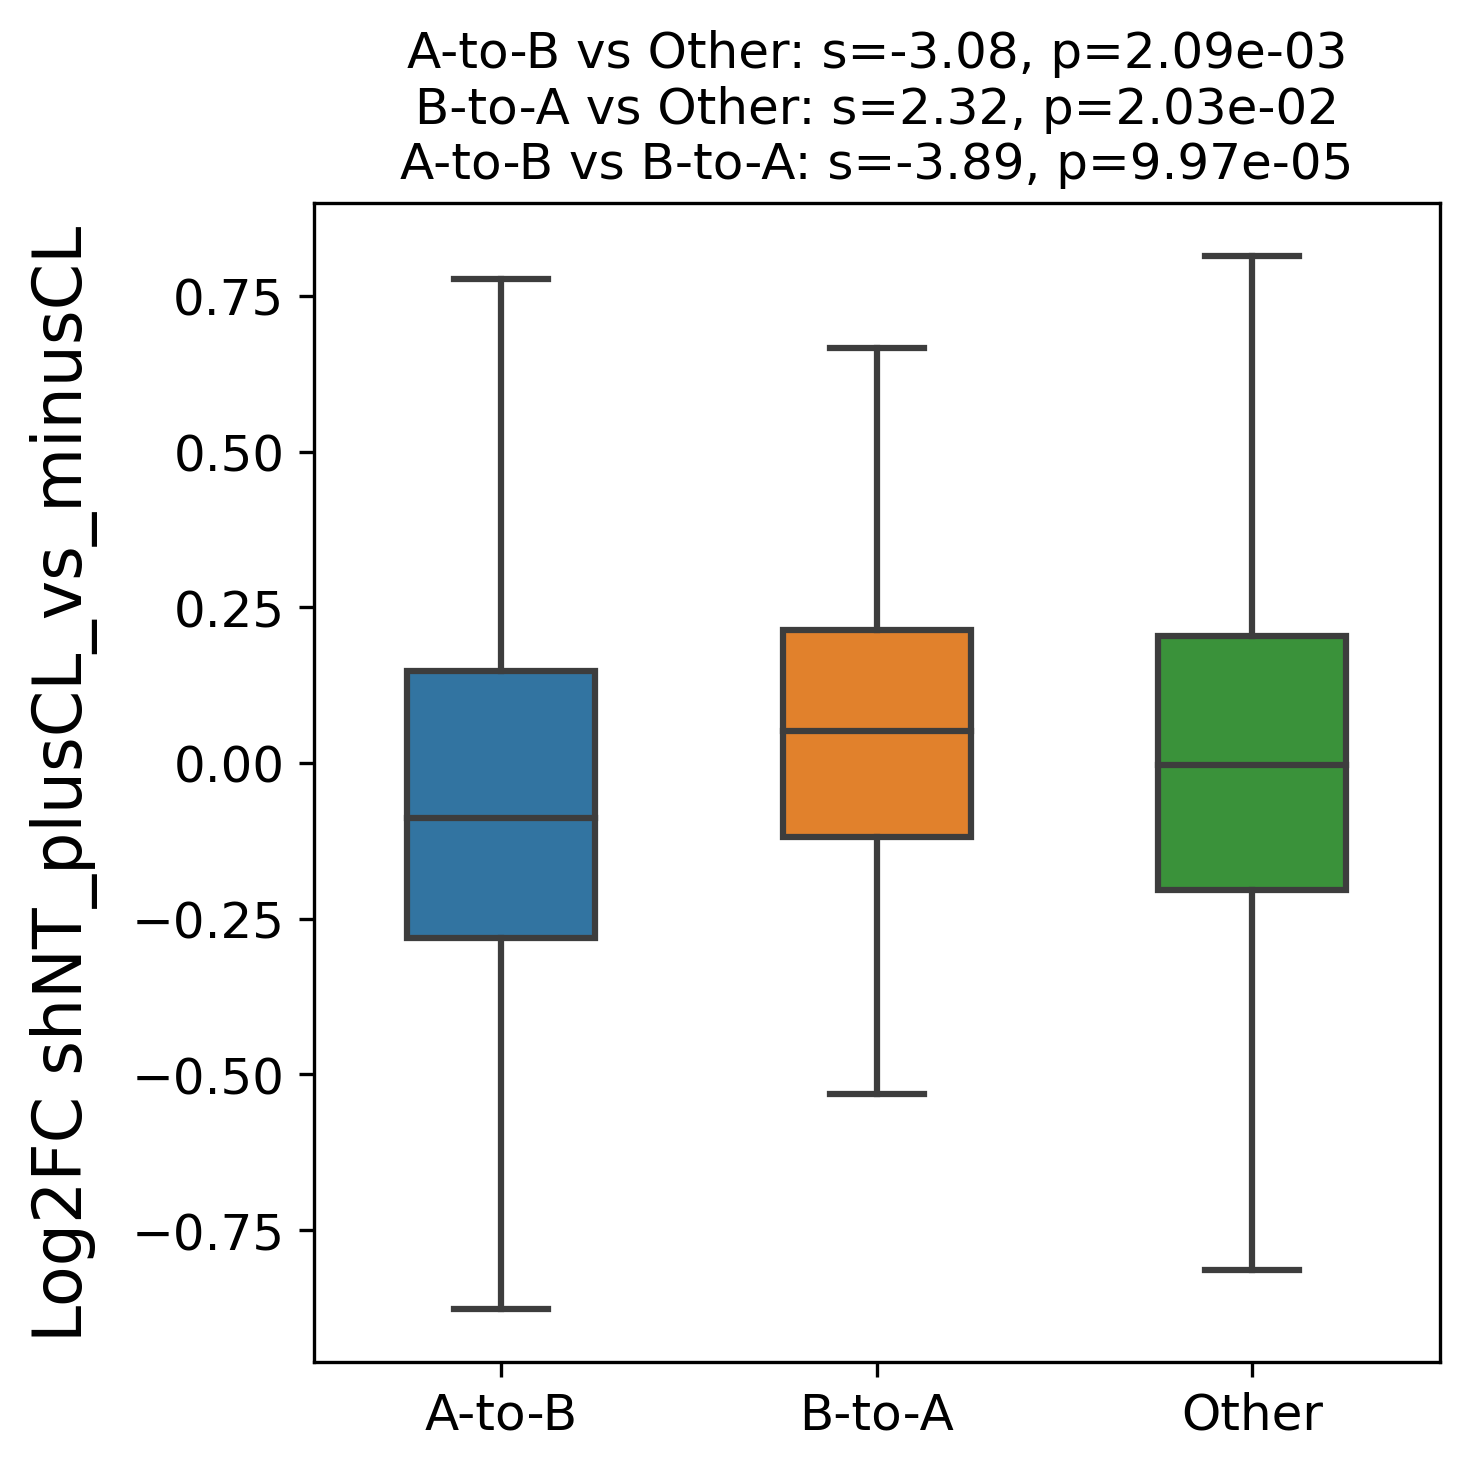

In [4]:
### identify switching AB compartment and check their correlation with expression change
r=50000
comp_clplus_shNT = pk.load(open('./merge_pairs_mapq5/remove100bp/cooltool_comp/shNT_plusCL_merge_mapq5_%s.cis_eigs.pk'%r, 'rb'))
comp_clplus_shNT_df = comp_clplus_shNT[1][['chrom','start','end','E1']]
comp_clplus_shNT_df['label'] = comp_clplus_shNT_df['chrom'].astype('str')+':'+comp_clplus_shNT_df['start'].astype('str')+':'+comp_clplus_shNT_df['end'].astype('str')

comp_clminus_shNT = pk.load(open('./merge_pairs_mapq5/remove100bp/cooltool_comp/shNT_minusCL_merge_mapq5_%s.cis_eigs.pk'%r, 'rb'))
comp_clminus_shNT_df = comp_clminus_shNT[1][['chrom','start','end','E1']]
comp_clminus_shNT_df['label'] = comp_clminus_shNT_df['chrom'].astype('str')+':'+comp_clminus_shNT_df['start'].astype('str')+':'+comp_clminus_shNT_df['end'].astype('str')

mm10_promoter = mm10_tss_ann.copy()
mm10_promoter['start'] = mm10_tss_ann['start'] - 2000
mm10_promoter['end'] = mm10_tss_ann['start'] + 2000
mm10_promoter = mm10_promoter[mm10_promoter['start']>0]
mm10_promoter['gene_name'] = [x[-1] for x in mm10_promoter['name'].str.split(':')]

comp, plot_df1, BtoA, AtoB = _compare_de_(treat_mat=comp_clplus_shNT_df, ctrl_mat=comp_clminus_shNT_df,
             comparison='shNT_plusCL_vs_minusCL', bed = mm10_promoter[['chr', 'start', 'end','gene_name']],
                       figsize = (5, 5), pdf = None)


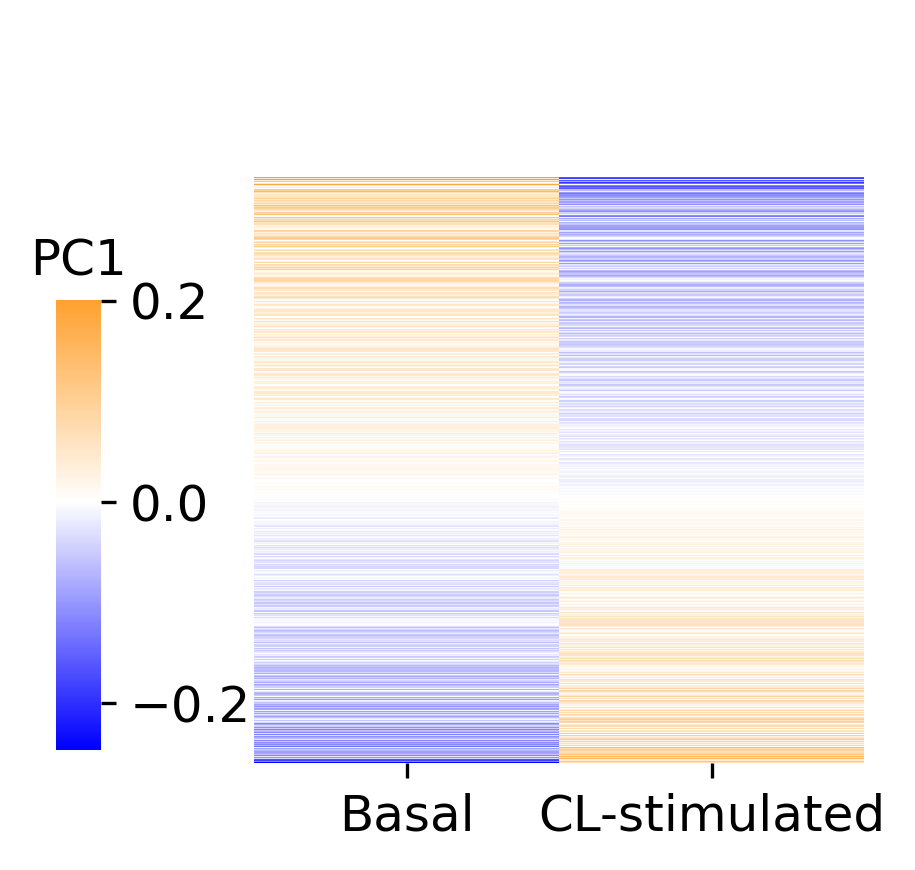

Type
A-to-B      606
B-to-A      505
Stable    48834
Name: Type, dtype: int64


In [5]:
### heatmap to show the PC1 values for switching A/B compartment

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("", ["blue",'white',"darkorange"])
plot_df = comp.query('group != "Other"')#[['ctrl', 'treat']].sort_values('treat')
plot_df = plot_df.loc[(plot_df['treat']-plot_df['ctrl']).sort_values().index,['ctrl', 'treat']]

sg = sns.clustermap(data = plot_df,
               tree_kws={"linewidths": 0.}, row_cluster = False, col_cluster = False,
               cmap = cmap, yticklabels=False, xticklabels=['Basal', 'CL-stimulated'],
              figsize = (3,3), cbar_pos = (0, 0.15, 0.05, .5), center = 0)
sg.ax_cbar.set_title('PC1')
plt.show()
# sg.savefig('Figures/AB_comp_heatmap.pdf')
plt.close()

### check the number of switching compartment
print(comp.groupby('Type')['Type'].count())



### TAD analysis

In [6]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                         "please check your cooltools version and update to the latest")

import cooltools
import collections
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
rc={"axes.labelsize": 16, "xtick.labelsize": 12, "ytick.labelsize": 12,
    "figure.titleweight":"bold", #"font.size":14,
    "figure.figsize":(5.5,4.2), "font.weight":"regular", "legend.fontsize":10,
    'axes.labelpad':8, 'figure.dpi':300}
plt.rcParams.update(**rc)



In [7]:
## read in calculated genome-wide contact insulation
resolution = 10000

insulation_score_dict = collections.defaultdict()
for cond in ['shNT', 'KD']:
    for treat in ['plusCL', 'minusCL']:
        insulation_score_dict[cond+'_'+treat] = pd.read_csv(f'./merge_pairs_mapq5/remove100bp/{cond}_{treat}_mapq5_merge.pairs_{resolution}_insulation_table.csv.gz', compression = 'gzip', index_col = 0)

resolution = 10000
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]


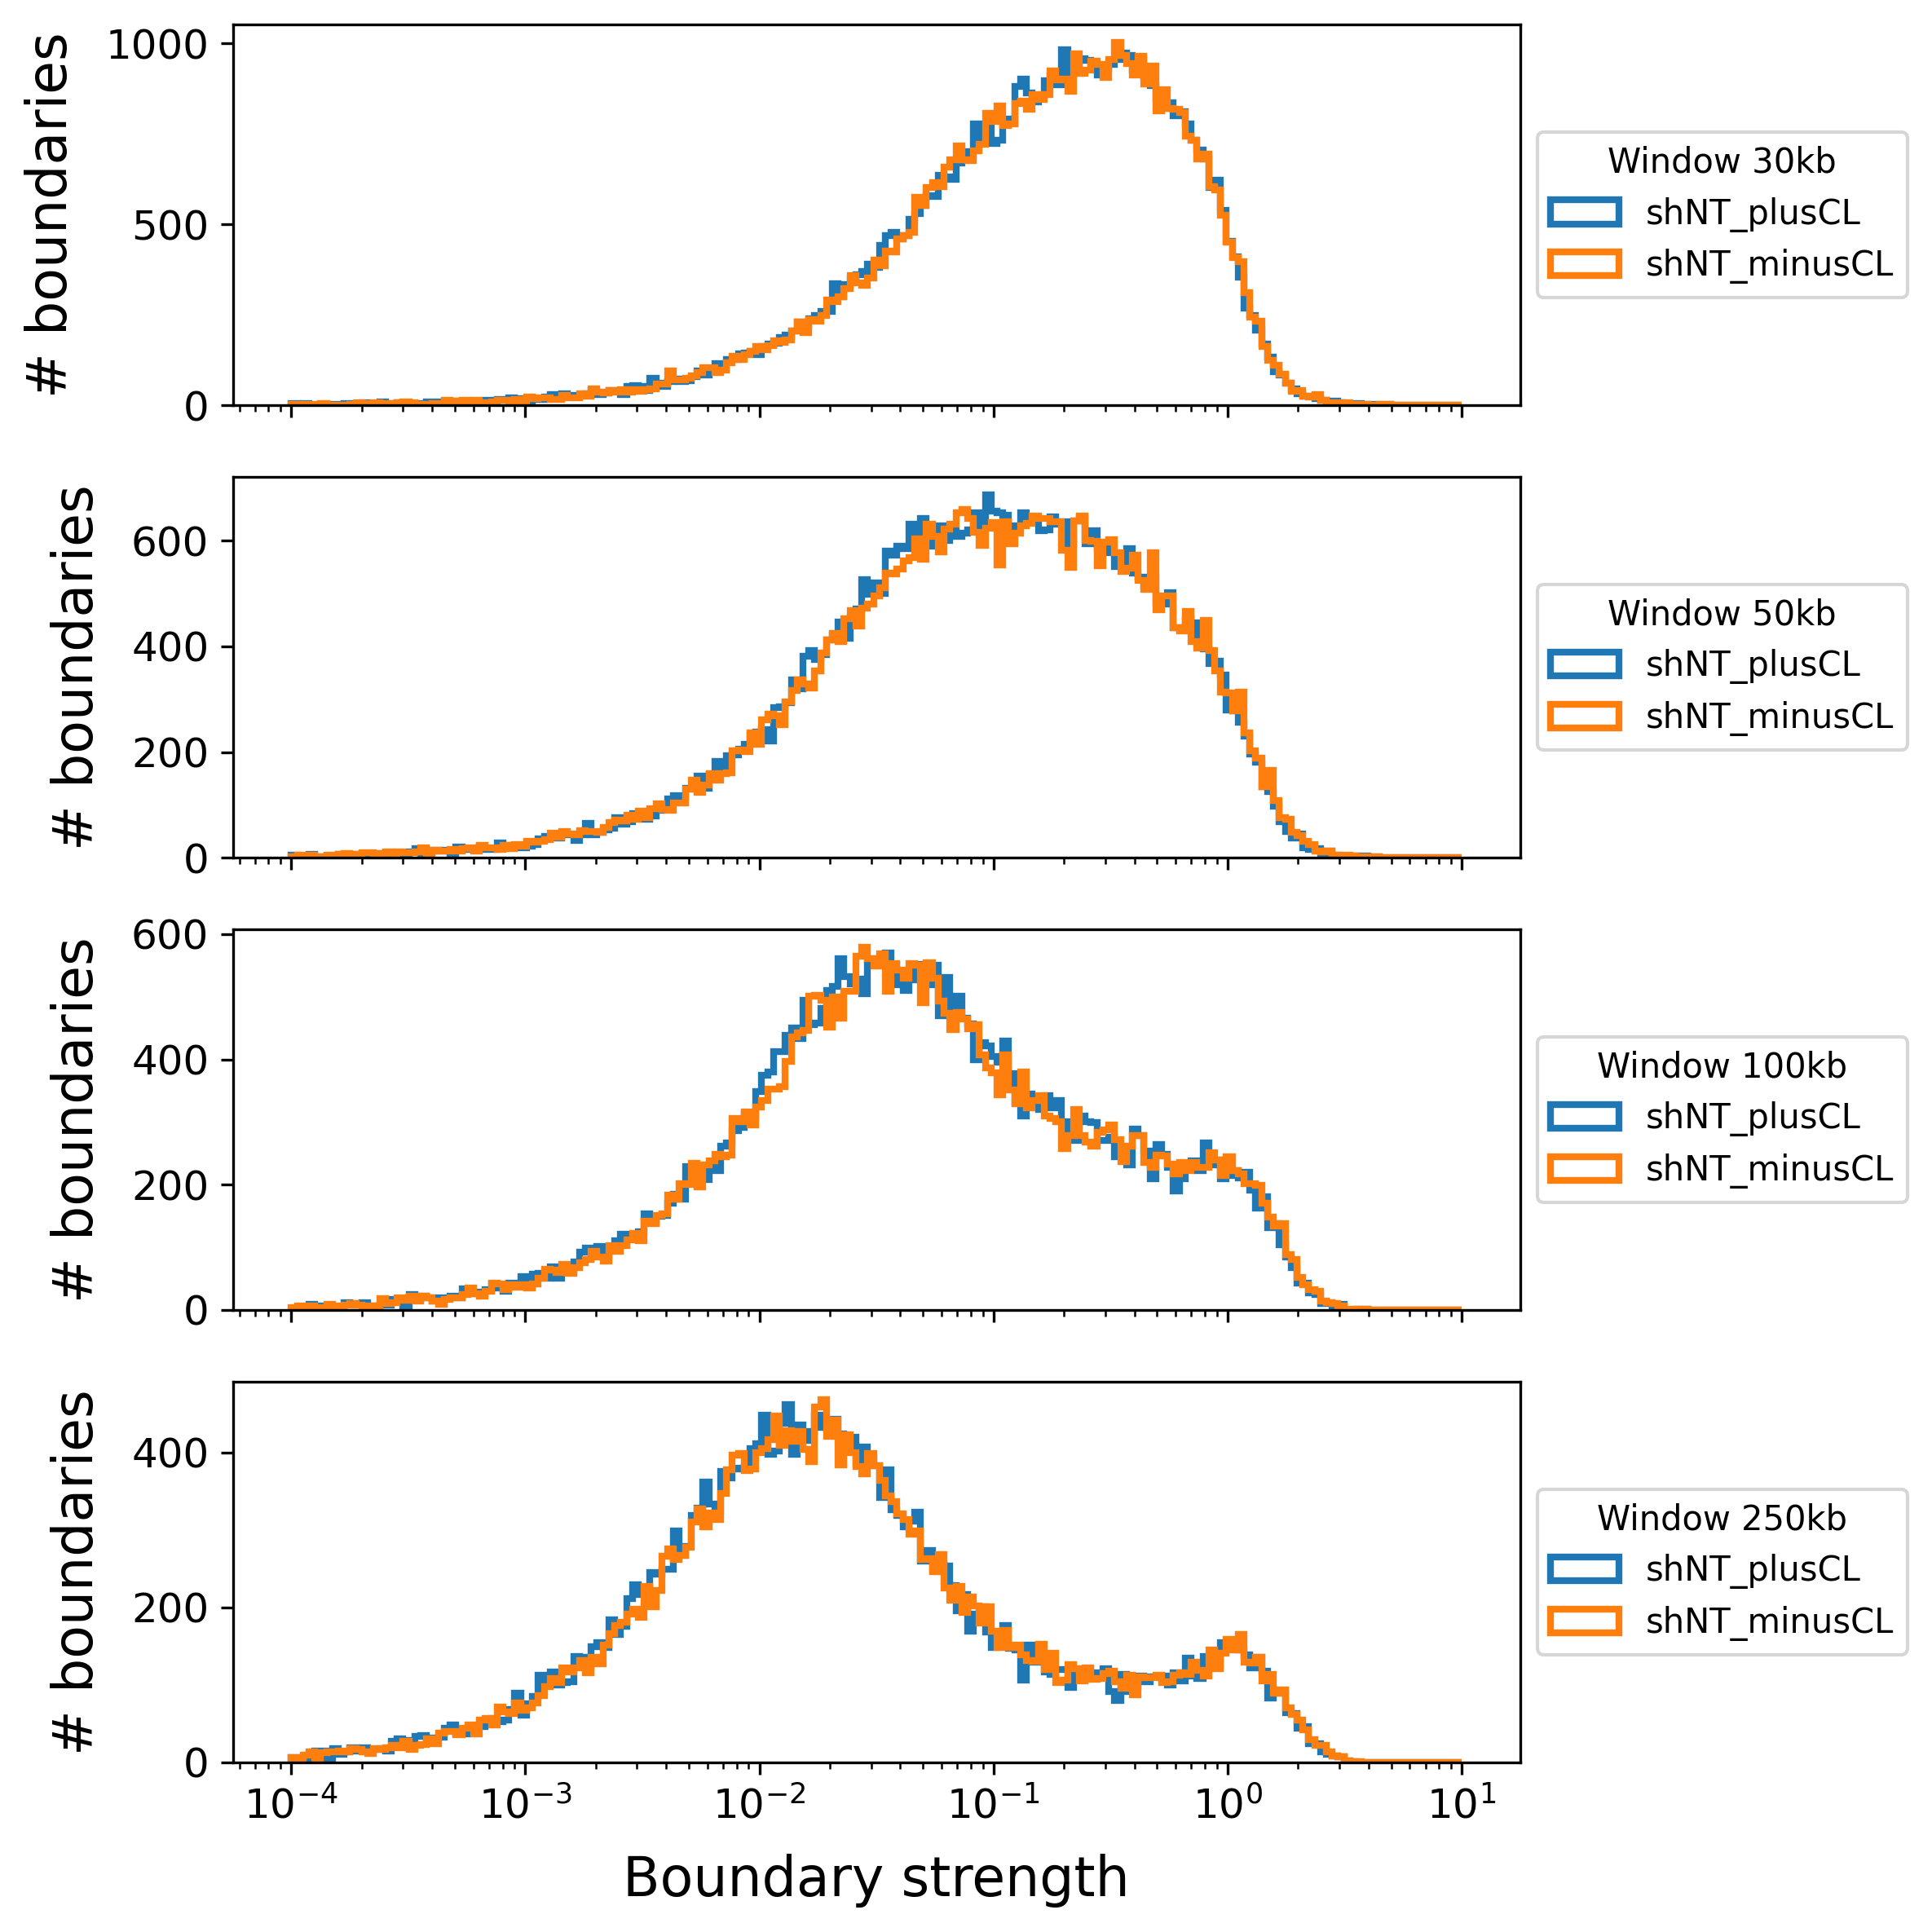

In [8]:
## plot distribution for insulation scores

histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

# condition = 'shNT_plusCL'
f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(8,8), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    for condition in ['shNT_plusCL', 'shNT_minusCL']:

        ax.hist(
            insulation_score_dict[condition][f'boundary_strength_{w}'],
            label = condition,
            **histkwargs
        )

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = f'Window {w//1000}kb')

axs[-1].set(xlabel='Boundary strength');
plt.tight_layout()
# f.savefig('Figures/TAD_boundary.pdf')
plt.show()
plt.close()


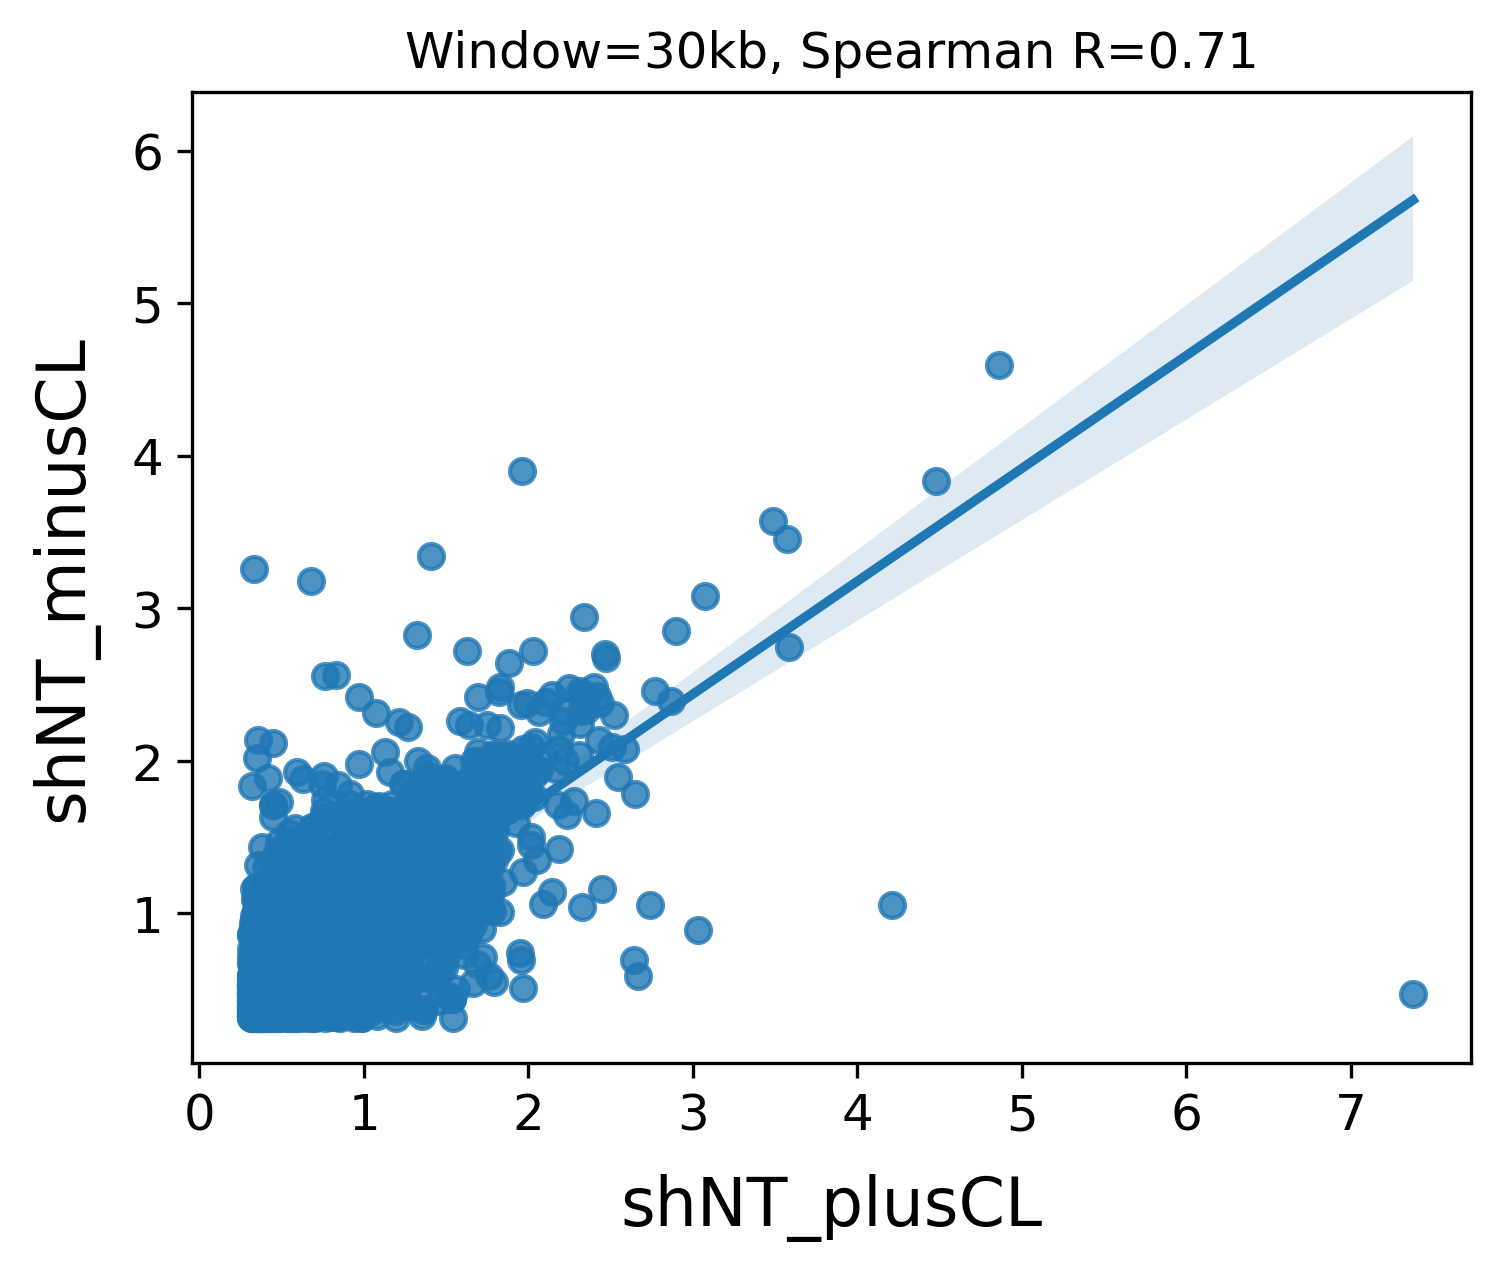

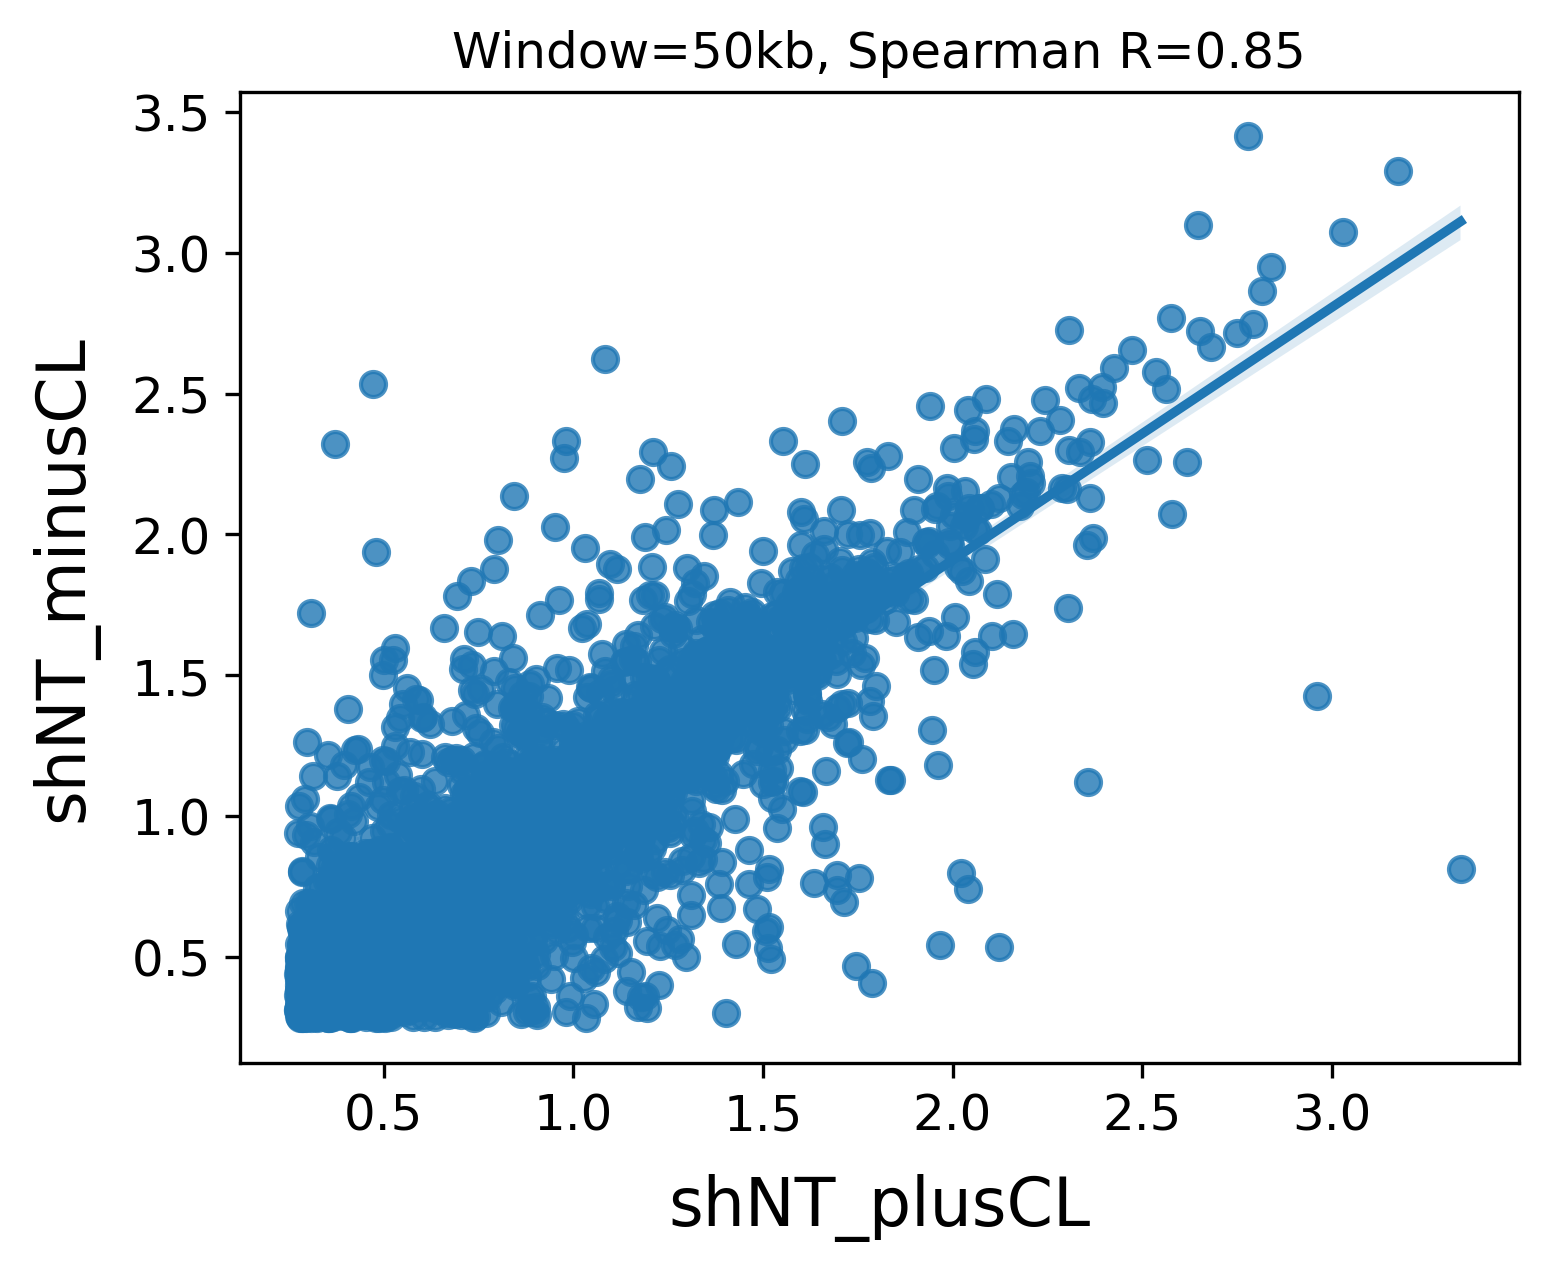

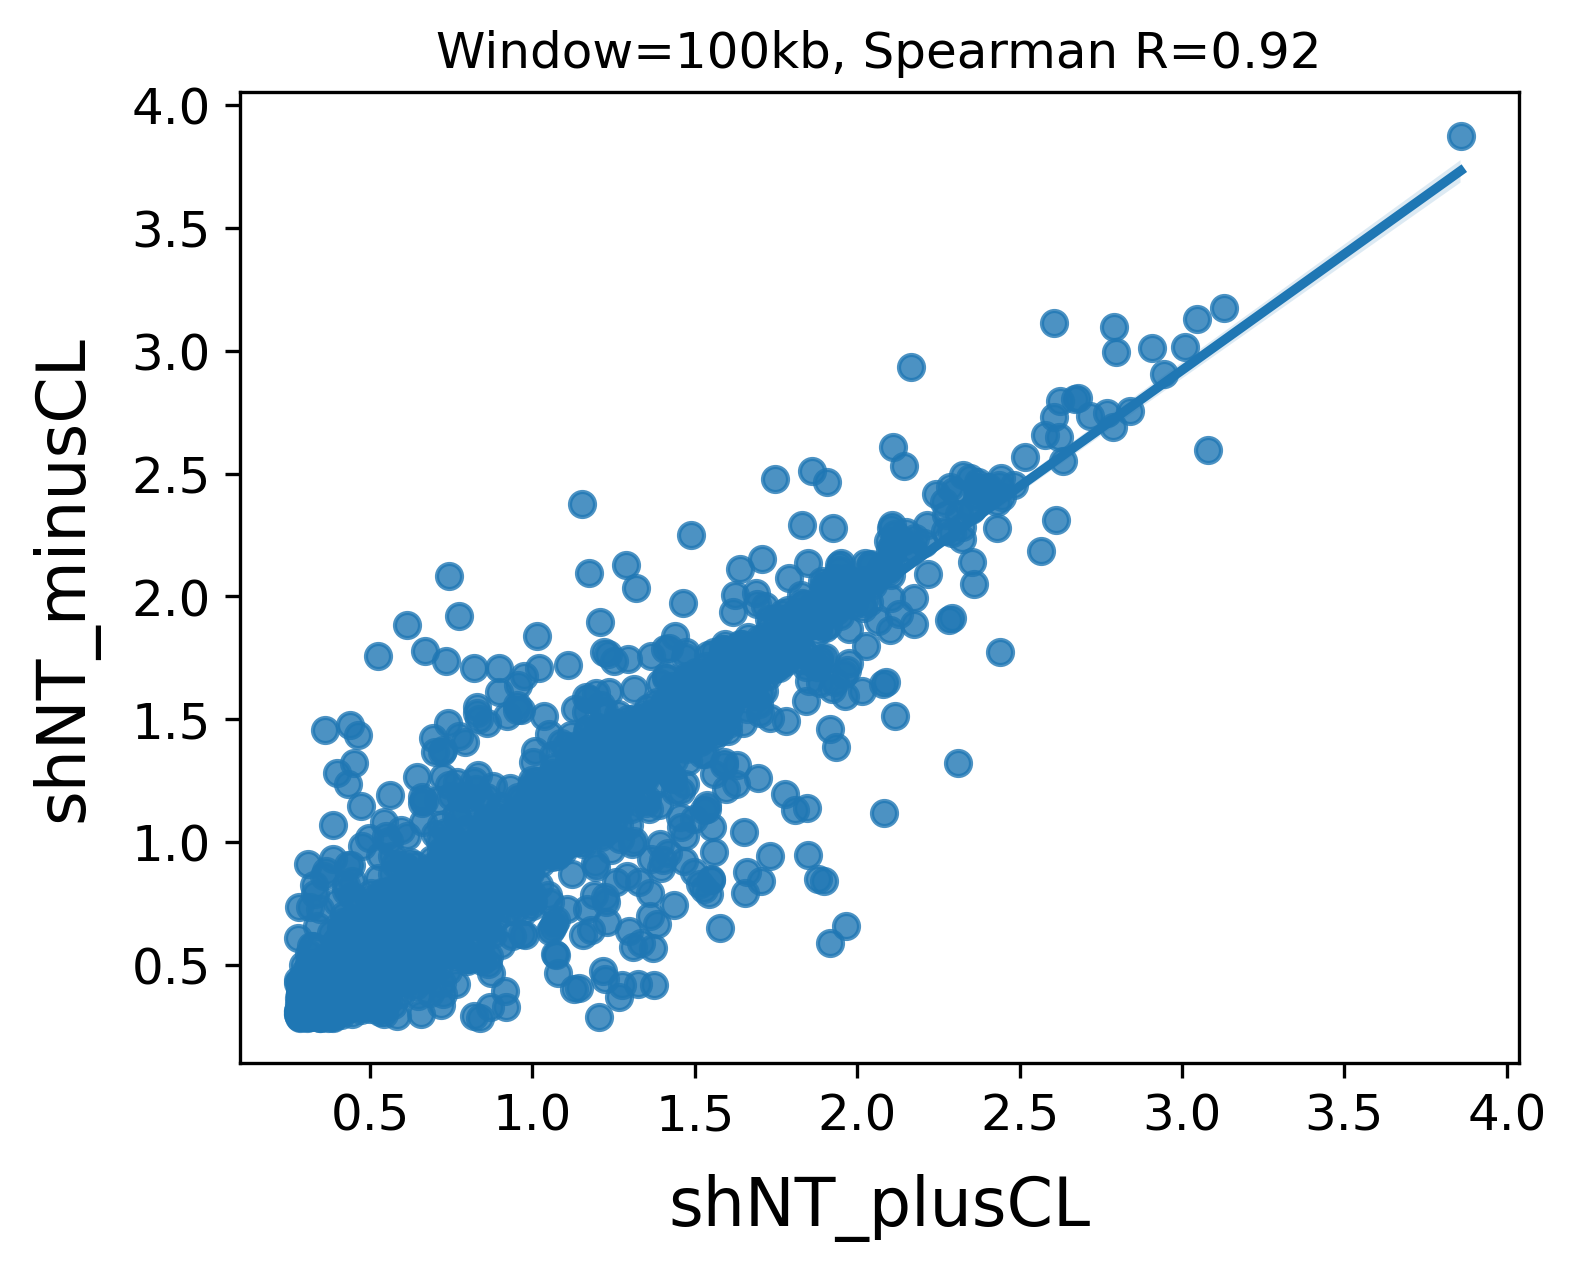

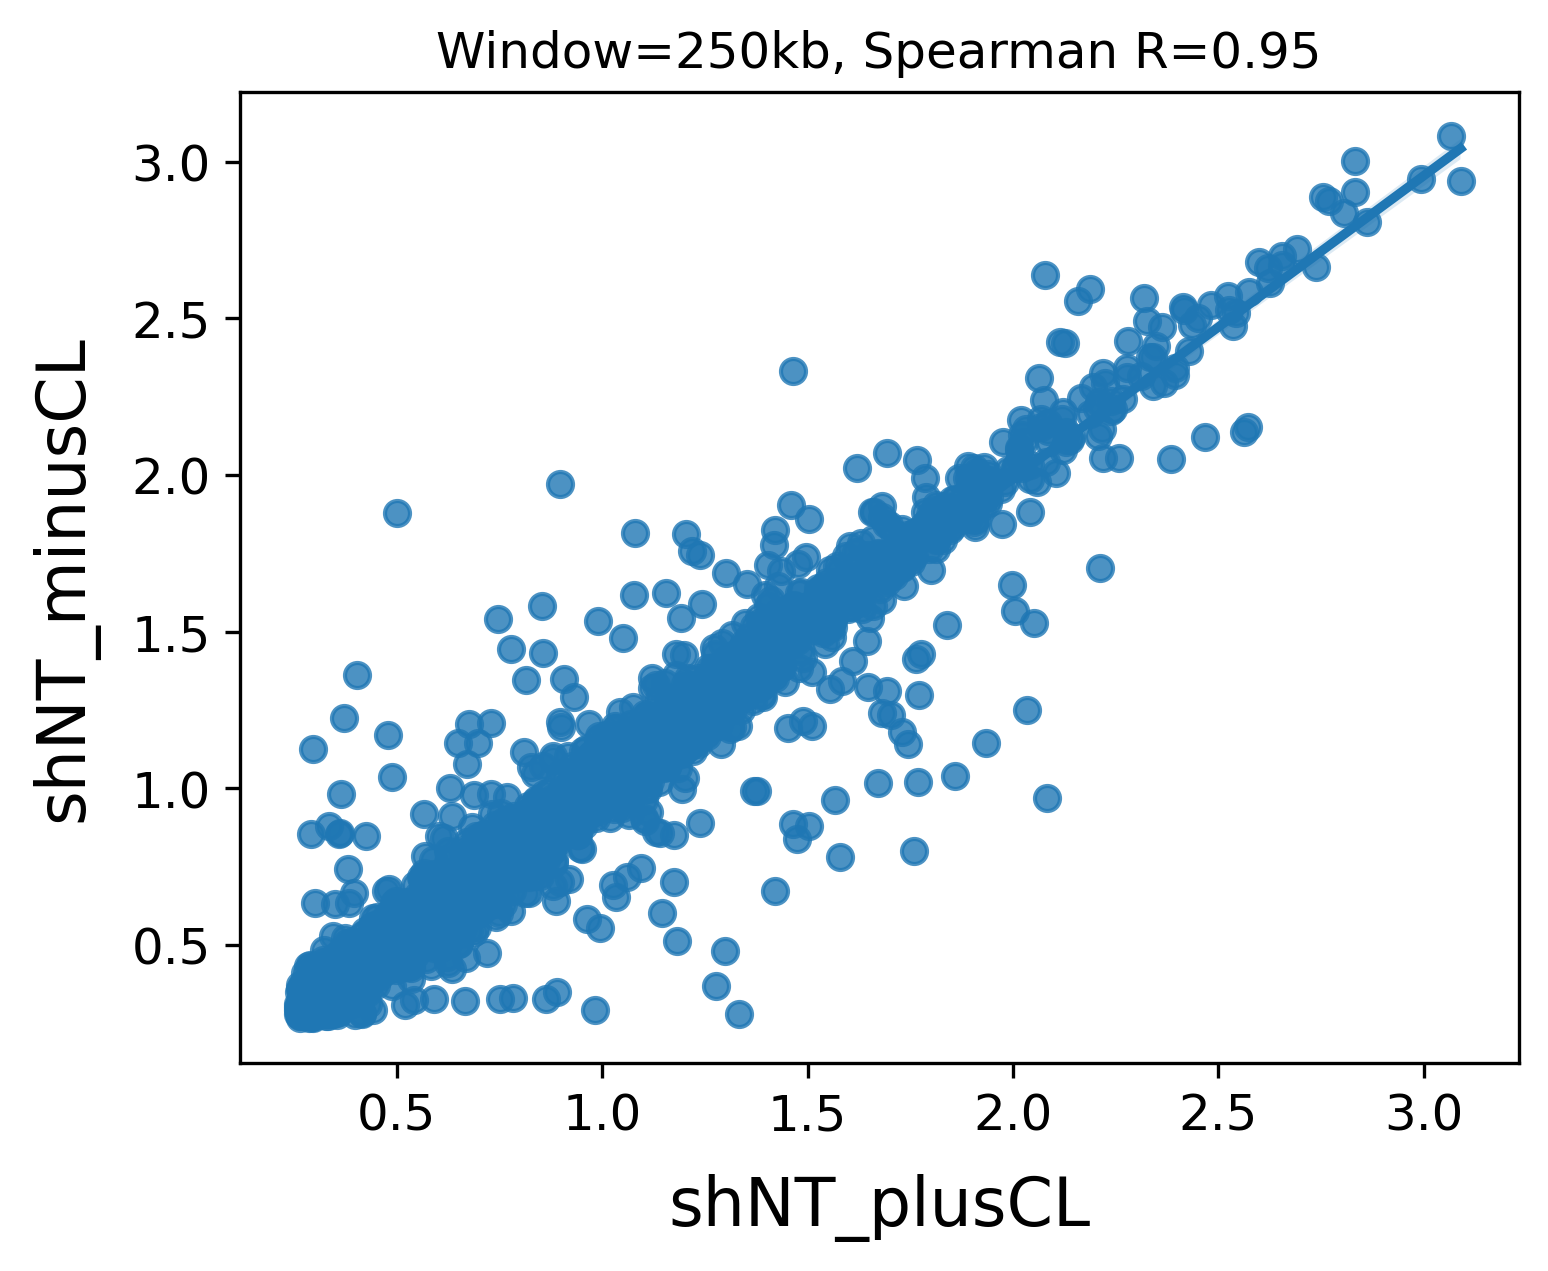

In [10]:
### plot for correlation of insulation score between two conditions
insulation_table_shNT_plusCL = insulation_score_dict['shNT_plusCL']
insulation_table_shNT_minusCL = insulation_score_dict['shNT_minusCL']

num_diff = {}
for w in windows:
    w = str(w)
    df1 = insulation_table_shNT_plusCL[insulation_table_shNT_plusCL['is_boundary_'+w]].query('is_bad_bin == False')
    df1['label'] = df1['chrom']+':'+df1['start'].astype('str')+'-'+df1['end'].astype('str')
    df2 = insulation_table_shNT_minusCL[insulation_table_shNT_minusCL['is_boundary_'+w]].query('is_bad_bin == False')
    df2['label'] = df2['chrom']+':'+df2['start'].astype('str')+'-'+df2['end'].astype('str')
    df = pd.merge(df1[['label', 'boundary_strength_'+w]], df2[['label', 'boundary_strength_'+w]],
                 left_on = 'label', right_on = 'label')
    df.columns = ['label', 'shNT_plusCL', 'shNT_minusCL']
    df['log2fold'] = np.log2(df['shNT_minusCL']) - np.log2(df['shNT_plusCL'])
    df['mean_strength'] = df[['shNT_minusCL', 'shNT_plusCL']].T.mean()
    df = df.sort_values('log2fold')
    
    r, p = spearmanr(df['shNT_plusCL'], df['shNT_minusCL'])

    fig, ax = plt.subplots()
#     sns.regplot(x = np.log2(df['shNT_plusCL']), y = np.log2(df['shNT_minusCL']))
    sns.regplot(x = df['shNT_plusCL'], y = df['shNT_minusCL'])
    ax.set(xlabel = 'shNT_plusCL',
          ylabel = 'shNT_minusCL',
          title = 'Window=%skb, Spearman R=%.2f'%(int(w)//1000, r))
    plt.show()
    num_diff[w] = [df.shape[0], df.query('log2fold > 1').shape[0], df.query('log2fold > 1').shape[0]*100/df.shape[0], df.query('log2fold < -1').shape[0], df.query('log2fold < -1').shape[0]*100/df.shape[0]]
num_diff = pd.DataFrame(num_diff, index = ['total', 'num_up', 'percentage_up', 'num_down', 'percentage_down']).T



In [11]:
### show the number of strongly changed boundary
print(num_diff.reset_index())



    index   total  num_up  percentage_up  num_down  percentage_down
0   30000  6571.0   189.0       2.876275     145.0         2.206666
1   50000  5125.0   102.0       1.990244      80.0         1.560976
2  100000  3443.0    33.0       0.958466      30.0         0.871333
3  250000  2069.0    14.0       0.676655      14.0         0.676655
